# Bayesian Learning Assignment 1

MSc DSAI Quentin Le Roux

<hr>
<hr>
<hr>

## Library Imports

In [1]:
# Imports display functions + widgets
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# Imports matplotlib library plus interactive widget (for exercise 3)
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

# Imports libraries for processing
import numpy as np
import pandas as pd
from scipy.stats import anderson, beta, norm, binom

<hr>

## Function declarations

**Note**: 
- *Functions are listed per exercise in alphabetical orders*
- *Functions are provided with Type Hinting*

### Exercise 1 functions

In [2]:
def compute_P_with_relative_frequencies(
    data:      pd.DataFrame, 
    case:      str, 
    condition: str
) -> float:
    """
    Computes a probability P given the relative frequencies found in 
    a given dataset.
    """
    # Retrieves:
    #    - The subset of the dataset on which to compute the relative 
    #      frequency given an input SQL-like query
    data = data.query(condition)
    #    - The subset of the subset with which to compute the relative 
    #      frequency given an input SQL-like query
    occurrences = data.query(case)
    frequency = occurrences["value"].sum()/len(data), data, occurrences
    return frequency

def compute_P_with_norm_distribution(
    data:        pd.DataFrame,
    side:        str,
    split_point: float
):
    """
    Approximate a probability using a normal distribution with the data.
    """
    # Computes the sample mean and standard deviation of a given dataset
    sample_mean = np.mean(data)
    sample_std_dev = np.std(data)
    # Approximates a normal distribution using the computed sample param.
    dist = norm(loc = sample_mean, scale=sample_std_dev)
    # Computes the probability of the data appearing on the left or right
    # side of the input split point
    if side == "left":
        P = dist.cdf(split_point)
    else:
        P = 1 - dist.cdf(split_point)
    return P

In [3]:
def import_dataset(
    path:      str, 
    index_col: bool = False, 
    header:    int  = 0, 
    sep:       int  = ","
) -> pd.DataFrame:
    """ 
    Imports a dataset (as a Pandas DataFrame) from a given .csv file.
    """
    data = pd.read_csv(
        path, 
        index_col = index_col, 
        header = header, 
        sep = sep
    )
    return data

In [4]:
def norm_testing(
    data: pd.DataFrame
)-> None:
    """ 
    Given a dataset formatted as a Pandas DataFrame, tests the null 
    hypothesis H0 that the data follows a univariate normal distribution.
    The function implements the Anderson-Darling test.
    """
    # Performs the Anderson-Darling test and retrieves the result for a 
    # 99% confidence interval
    test = anderson(data)
    result = test[0] <= test[1][4]
    result = "accept" if result else "reject"
    # Prints the result
    print(f"Given a 99% confidence level, we can {result} the null " + \
          "hypothesis H0 that the data follows a normal " + \
          "distribution (Anderson-Darling normality test).")

### Exercise 2 functions

In [5]:
def compute_posterior_theta(
    sigma:       int,
    tau:         int,
    theta_prior: int,
    data_mean:   int,
    list_of_Ns:  list
) -> list:
    """
    For a given list of sample sizes n, computes the mean, variance, 
    and 95% confidence interval of a posterior variable given that it 
    follows a normal distribution with parameters computed below as 
    variables <mean> and <var>.
    """
    # Generates an empty list to store and return results
    results = []
    for n in list_of_Ns:
        # Generares the parameters of the posterior normal distribution
        mean = (sigma**2 * theta_prior + n * tau**2 * data_mean) / \
               (sigma**2 + n * tau**2)
        var = (tau**2 * sigma**2) / (sigma**2 + n * tau**2)
        # Generates the 95% confidence interval for a normal distribution 
        # with the previously generated parameters using the scipy 
        # library.
        # Note: scale corresponds to the standard deviation
        interval = norm.interval(0.95, loc=mean, scale=var**(1/2))
        # Appends the result
        results.append((n, mean, var, interval))
    return results

### Exercise 3 functions

In [6]:
def beta_distribution_plot(
    a: float, 
    b: float
) -> None:
    """
    Given a beta distribution with input <a> and <b> parameters, 
    plots the histogram of random samples from the distribution. 
    Superposed, the corresponding probability density function 
    is also plotted.
    """
    # Plots the distribution using the code provided the following 
    # scipy documentation page: 
    # docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
    # Samples the beta distribution
    data = beta.rvs(a, b, size=1000)
    # Computes the beta pdf
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    pdf = beta.pdf(x, a, b)
    # Plots the sampled data and pdf
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, pdf, 'r-', lw=5, alpha=0.6, label='beta pdf')
    ax.hist(data, density=True, histtype="stepfilled", alpha=0.2)
    ax.legend(loc="best", frameon=False)
    plt.show()
    
def beta_distribution_sliderplot(
    a: float, 
    b: float, 
    n: float, 
    k: float
) -> tuple:
    """
    Plots a posterior beta distribution with input <a> and <b> (prior 
     parameters) and <n> and <k> (data likelihood parameters).
    ---
    /!\ The function returns <fig>, <ax>, and the slider objects
    so the resulting plot remains dynamic (updatable by the user) 
    outside of the function's scope. See info here:
    > https://github.com/matplotlib/matplotlib/issues/3105
    """
    # creates the parameters of the posterior (updated) beta distribution
    a = k+a
    b = n-k+b
    # Creates subplot
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.35)
    # Creates the data to be plotted
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    y = beta.rvs(a, b, size=1000)
    z = beta.pdf(x, a, b)
    s = np.quantile(y, [0.05, 0.5, 0.95])
    # Computes the distribution's quantities:
    #     mean, median, variance, 95% confidence interval
    mean = round(beta(a,b).mean(),3)
    median = round(beta(a,b).median(),3)
    variance = round(beta(a,b).var(),3)
    CI = (round(s[0],3), round(s[2],3))
    # Plots the base plot
    ax.plot(x, z, "r-", lw=5, alpha=0.6, label="beta pdf")
    ax.hist(y, density=True, histtype="stepfilled", alpha=0.2)
    ax.axvline(x=beta(a,b).mean(), label="mean")
    ax.legend()
    plt.suptitle(f"Beta Distribution, alpha={round(a,1)}, " + \
                 f"beta={round(b,1)}\n" + \
                 f"mean={mean}, med={median}, var={variance}, " + \
                 f"CI95%: [{CI[0]}, {CI[1]}]")
    # Creates the axes for the sliders of the Beta 
    # distribution's parameters
    alp = plt.axes([0.20, 0.15, 0.65, 0.03])
    bet = plt.axes([0.20, 0.1, 0.65, 0.03])
    alpS = Slider(alp, 'alpha', 0., 1000., a)
    betS = Slider(bet, 'beta', 0., 1000., b)
    # Creates a function to be called when sliders are modified
    def update(val):
        # Retrieves the updated Beta parameters
        a = alpS.val
        b = betS.val
        # Creates the new data to be plotted
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
        y = beta.rvs(a, b, size=1000)
        z = beta.pdf(x, a, b)
        s = np.quantile(y, [0.05, 0.5, 0.95])
        # Computes the updated distribution's quantities
        mean = round(beta(a,b).mean(),3)
        median = round(beta(a,b).median(),3)
        variance = round(beta(a,b).var(),3)
        CI = (round(s[0],3), round(s[2],3))
        # Clears the current plot and redraws it
        ax.cla()
        ax.plot(x, z, "r-", lw=5, alpha=0.6, label="beta pdf")
        ax.hist(y, density=True, histtype="stepfilled", alpha=0.2)
        ax.axvline(x=beta(a,b).mean(), label="mean")
        ax.legend()
        plt.suptitle(f"Beta Distribution, alpha={round(a,1)}, beta={round(b,1)}\n" + \
                     f"mean={mean}, med={median}, var={variance}, " + \
                     f"CI95%: [{CI[0]}, {CI[1]}]")
    # Calls the update function when the sliders are modified
    alpS.on_changed(update)
    betS.on_changed(update)
    # Displays the graph
    plt.show()
    # returns the objects that allows the graph to remain dynamic 
    # within the notebook
    return fig, ax, alpS, betS

In [7]:
def compute_priors_impact_on_posterior_beta_distribution(
    n: float, 
    k: float
) -> pd.DataFrame:
    """
    Computes the impact of a beta distribution prior (by varying its
    alpha and beta parameters) on a posterior beta distribution and 
    stores the resulting quantities (mean, median, 95% confidence 
    interval, etc.) as a Pandas DataFrame.
    """
    # Computes a range of prior parameters and the list of their 
    # permutations
    alpha_priors = [1] + list(range(5, 51, 5))
    beta_priors = [1] + list(range(5, 51, 5))
    permutation_pairs = [
        [ai, bi] for ai in alpha_priors for bi in beta_priors
    ]
    
    # Creates an empty list to store intermediary results
    results = []
    # Computes the posterior mean, median, and 95% confidence 
    # interval per permutation of prior parameters
    for a, b in permutation_pairs:
        alp = a + k
        bet = b + n - k
        sample = np.random.beta(alp, bet, size = 1000)
        sample_stats = np.quantile(sample, [0.05, 0.5, 0.95])
        results.append(
            [a, b, alp, bet, 
             beta.mean(a=alp, b=bet), 
             beta.median(a=alp, b=bet), 
             [round(sample_stats[0],3), round(sample_stats[2],3)],
             sample_stats[2] - sample_stats[0]
            ]
        )
    # Stores the results
    results = pd.DataFrame(
        results, 
        columns = ["alpha", "beta", "post. alpha", "post. beta", 
                   "post. mean", "post. median", "95% post. CI", "CI spread"]
    )   
    # Computes a heatmap of the posterior mean
    heat_postmean = results[
        ["alpha", "beta", "post. mean"]
    ].pivot(index ='alpha', columns ='beta')
    heat_postmean = heat_postmean.style.background_gradient(
        cmap ='viridis'
    ).set_properties(**{'font-size': '12px'})
    # Computes a heatmap of the posterior median
    heat_postmedian = results[
        ["alpha", "beta", "post. median"]
    ].pivot(index ='alpha', columns ='beta')
    heat_postmedian = heat_postmedian.style.background_gradient(
        cmap ='viridis'
    ).set_properties(**{'font-size': '12px'})
    return results, heat_postmean, heat_postmedian

In [8]:
def plot_numerical_approximation_posterior(
    a: float, 
    b: float, 
    n: float, 
    k: float
) -> None:
    """
    Plots the distribution of the prior, data likelihood, and posterior
    of a posterior beta distribution given a binomial data likelihood
    and prior beta distribution with respective parameters n and k, and 
    a and b.
    """
    # Creates a parameter space for theta
    theta = np.arange(0,1,0.01)
    # Computes the beta distribution prior on the parameter space
    prior = beta(a, b).pdf(theta)
    ## Estimates the posterior 
    #     - Computes the data likelihood for each parameter value
    likelihood = binom.pmf(k, n, theta) 
    #     - Computes the posterior  
    posterior = likelihood * prior
    # Plots the data likelihood
    plt.figure(figsize=(9,6))
    plt.subplot(2, 2, 1)
    plt.plot(theta,likelihood)
    ml_est = np.argmax(likelihood)
    plt.title(r"Binomial likelihood $p(y|\theta)$" + \
              f"\nml estimate = {round(theta[ml_est], 2)}")
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.xlabel(r"$\theta$")
    plt.axvline(x = theta[ml_est], linewidth=0.5, color = "black")
    # Plots the prior
    plt.subplot(2, 2, 2)
    plt.plot(theta,prior)
    mean = prior.mean()
    plt.title(r"Beta Prior $p(\theta)$" + "\n" \
              r"$\alpha=$" + f"{a}" + r"$, \beta=$" + \
              f"{round(b, 2)}, mean = {round(mean, 2)}")
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.xlabel(r"$\theta$")
    plt.axvline(x = mean, linewidth=0.5, color = "black")
    # Plots the posterior
    plt.subplot(2, 1, 2)
    plt.plot(theta,posterior)
    mean = np.sum(theta*posterior)/np.sum(posterior)
    plt.title(r"Posterior $p(\theta|y)$" + f"\nmean = {round(mean, 2)}")
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.axvline(x=mean, linewidth=0.5, color = "black")
    plt.xlabel(r"$\theta$")
    # Prints the plot
    plt.tight_layout()
    plt.show()

def plot_z_vsX_and_distribution(
    x: pd.Series, 
    z: pd.Series
) -> norm:
    """
    Computes a normal distribution given a mean and standard deviation
    yielded from the provided <z> data. Draws the spread of <z> against 
    <x> and the histogram of <z> against the curve drawn by the 
    computed normal distribution.
    """
    # Computes the mean and standard deviation of z
    sample_mean = np.mean(z)
    sample_std_dev = np.std(z)
    print(f"Z: sample mean = {round(sample_mean,4)}, " + \
          f"sample std.dev. ={round(sample_std_dev,4)}")
    # Computes the normal distribution with the z-parameters
    dist = norm(loc = sample_mean, scale = sample_std_dev)
    # Declares the plot
    plt.figure(figsize=(9,4))
    # Declares subplot #1: 
    #     z versus x spread
    plt.subplot(1, 2, 1)
    plt.scatter(x, z, s=3)
    plt.xlabel('x')
    plt.ylabel('z = y - x')
    plt.title('z vs x')
    # Declares subplot #2: 
    #     z-histogram and normal distribution w/ parameters 
    #     derived from z
    plt.subplot(1, 2, 2)
    #     Declares the histogram of the z-data
    n, bins, patches  = plt.hist(
        z, 50, density=True, facecolor="g",  alpha= 0.75
    )
    #     Draws the curve of the normal distribution w/ parameters
    #     derived from z
    plt.scatter(z, dist.pdf(z), color = "black")
    plt.xlabel("z = y vs x")
    plt.ylabel("probability")
    plt.grid(True)
    # Prints the plot
    plt.tight_layout()
    plt.show()
    return dist

<hr>

## Exercise 1

**Using the football dataset, estimate the following conditional probabilities in two different ways (one through relative frequencies and one using an approximated distribution):**

- P1: Pr(Favorite wins | point spread = 8)
- P2: Pr(Favorite wins by at least 8 points | point spread = 8)
- P3: Pr(Favorite wins by at least 8 points | point spread = 8 and favorite wins)

**ASSUMPTIONS**: 

> *Games with a point spread of 0 are ignored as it indicates that there is no favorite*
>
> *Tied games yield a half-point when counting the number of wins in the dataset* (assumption carried over from the exercise from class 3*)

<u>__*__ Note:</u> There is no tied game when the point spread is equal to 8 (See the "Importing the data" subsection below). As such, the second assumption carried over from class 3 does not matter.

### Summary of computed frequencies (See below for the calculations)

*Values were rounded to 4 decimals*.

| method | Frequencies | Approximated Distribution (method 1) | Approximated Distribution (method 2) |
| --- | --- | --- | --- |
| P1 | 0.7551 | 0.7267 | 0.7695 |
| P2 | 0.449 | 0.5059 | 0.4992 |
| P3 | 0.5946 | 0.6962 | 0.7181 |


#### Methods used for the approximated distribution approach
The method 1 reproduces the method used during class 3, where the quantity $z=y-x$ (with $x$, the original spread data, and $𝑦$ the original outcome data) is computed and used to approximate a normal distribution.

The method 2 relies on testing the normality of the outcome data after pre-processing (i.e. accounting for the conditions to build the P1, P2, P3 probabilities) and then approximating the resulting data distribution accordingly (after testing, we rely on the Gaussian distribution for the three probabilities).

#### Comment on the results

We see that the frequency-based and approximated distribution-based methods for P1 and P2 yield similar results. This is not the case for P3 where frequencies and approximated distributions methods differ noticeably. This might indicate that approximating the distribution of the data given P3's conditions via a normal distribution is not fitting, likely because of lack of data.

### Importing the data

In [9]:
# Imports the football dataset

football_dataset_path = 'football_dataset.txt'
original_data = import_dataset(football_dataset_path)

In [10]:
# Removes the entries with a point spread of 0, as it indicates 
# there is no favorite

football_data = original_data[~(original_data["spread"]==0)].copy() 
# copy is used because of SettingWithCopyWarning

# Computes an outcome column

football_data["outcome"] = football_data["favorite"] - \
                           football_data["underdog"]

# Keeps the spread and outcome columns only

football_data = football_data[["outcome", "spread"]]

# Creates a value column to count the number of wins
scorer = lambda x: 0 if x<0 else 1 if x>0 else 0.5
football_data["value"] = football_data["outcome"].apply(scorer)

To be sure, we verify that there is no tied game when the spread is equal to 8.

In [11]:
football_data.query("outcome == 0 & spread == 8")

,outcome,spread,value


### Computing P1

#### Frequency approach

$$P1=\mathbb{P}(Favorite\,\,wins\,\,|\,\,point\,\,spread\,\,=\,\,8)$$

In [12]:
### Computes P1 with relative frequencies

P1, data, _ = compute_P_with_relative_frequencies(
    football_data, "outcome >= 0", "spread == 8"
)
print(f"Computed with relative frequencies, P1: {round(P1, 4)}" + \
      " (rounded to 4 decimals)")

Computed with relative frequencies, P1: 0.7551 (rounded to 4 decimals)


#### Approximated distribution approach

<u>Method 1:</u>

We set $x$ as the original spread data, and $y$ the original outcome data (original meaning before the application of query filters such as "spread==8"), and $z$ the difference between the two such that:
$$z = y-x$$

In [13]:
football_data.head()

,outcome,spread,value
0,8,2.0,1.0
1,27,9.5,1.0
2,31,4.0,1.0
3,-7,4.0,0.0
4,6,4.5,1.0


In [14]:
x = football_data["spread"]
y = football_data["outcome"]
z = y - x

We plot the spread of $z$ versus that of $x$, as well as the histogram of $z$ superimposed with the normal distribution with parameters $\mu$ and $\sigma^2$ derived from $z$.

Z: sample mean = 0.2013, sample std.dev. =13.6046


<IPython.core.display.Javascript object>


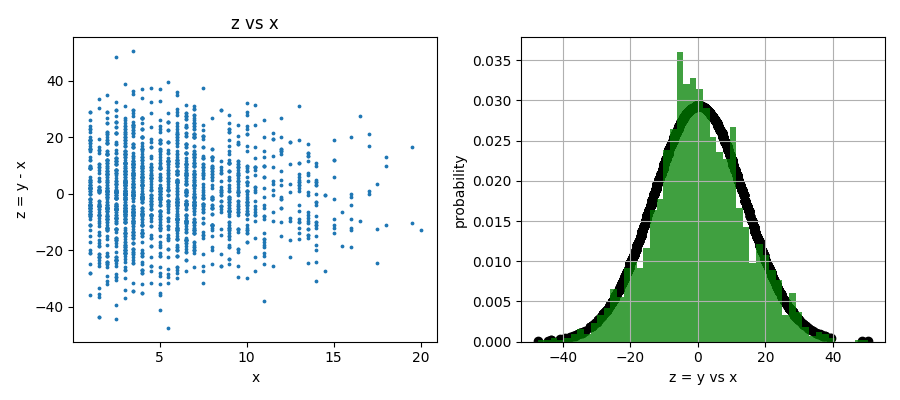

In [15]:
dist = plot_z_vsX_and_distribution(x, z)

**Observation**: Plotting z versus x seems to suggest that z is distributed independently from x. 

> We could reasonably model the distribution of z independently from x. The histogram plot above shows the empirical distribution of z with a superimposed, fitted normal distribution. This suggests that it may be acceptable to approximate the distribution of the random variable z as a Gaussian distribution with mean $\mu=\bar{z}\approx0.2013$ and standard deviation $\sigma=s_z\approx13.6046$. 

As such, we assume that z is independent from x and z follows a Gaussian distribution such that $z|x \sim \mathcal{N}(\mu, \sigma^{2})$. 

**Note**: The model is not perfect -- it does not exactly fit the data

> The model describes continuously-valued quantites while game scores or point-spreads are discrete. However, such a model provides an approximation that can be used to assign probabilities to events.

As such, we find:

\begin{align}
P(y \ge 0 | x=8) &= P(z+x \ge 0 | x=8)\\
&= P(z \ge -x | x=8) \\
&= 1 - P(z < -x | x=8) \\
&= 1 - P(z<-8) \tag{assumed independence of z and x}\\
\end{align}

Given $z\sim \mathcal{N}(\mu, \sigma^{2})$, we can easily compute the corresponding Cumulative Distribution Function (CDF).

In [16]:
P1 = 1 - dist.cdf(-8)
print(f"Computed with an approximated normal distribution, P1: " + \
      f"{round(P1, 4)} (rounded to 4 decimals)")

Computed with an approximated normal distribution, P1: 0.7267 (rounded to 4 decimals)


<u>Method 2 (Anderson-Darling test on the data itself):</u>

In [17]:
# Reuses the data pre-computed with the frequencies approach

data.head()

,outcome,spread,value
84,21,8.0,1.0
98,-3,8.0,0.0
130,-3,8.0,0.0
223,13,8.0,1.0
248,-7,8.0,0.0


In [18]:
# Tests the gaussian-ness of the data with an Anderson-Darling test

data = data["outcome"]
norm_testing(data)

Given a 99% confidence level, we can accept the null hypothesis H0 that the data follows a normal distribution (Anderson-Darling normality test).


In [19]:
# Computes P(y>=0|x=8) directly, given the pre-processed dataset

P1 = compute_P_with_norm_distribution(data, "right", 0)
print(f"Computed with an approximated normal distribution, P1: " + \
      f"{round(P1, 4)} (rounded to 4 decimals)")

Computed with an approximated normal distribution, P1: 0.7695 (rounded to 4 decimals)


### Computing P2

#### Frequency approach

$$P2=\mathbb{P}(Favorite\,\,wins\,\,by\,\,at\,\,least\,\,8\,\,points\,\,|\,\,point\,\,spread\,\,=\,\,8)$$

In [20]:
# Computes P2 with relative frequencies

P2, data, _ = compute_P_with_relative_frequencies(
    football_data, "outcome >= 8", "spread == 8"
)
print(f"Computed with relative frequencies, P2: {round(P2, 4)} " + \
      " (rounded to 4 decimals)")

Computed with relative frequencies, P2: 0.449  (rounded to 4 decimals)


#### Approximated distribution approach

<u>Method 1:</u>

We set $x$ as the original spread data, and $y$ the original outcome data (original meaning before the application of query filters such as "spread==8"), and $z$ the difference between the two such that:
$$z = y-x$$

**Plot**: Similar as previously displayed

**Observation**: Similar as previously stated

**Note**: Similar as previously stated

We find:

\begin{align}
P(y \ge 8 | x=8) &= P(z+x \ge 8 | x=8)\\
&= P(z \ge -x + 8 | x=8) \\
&= 1 - P(z < -x + 8 | x=8) \\
&= 1 - P(z<0) \tag{assumed independence of z and x}\\
\end{align}

Given $z\sim \mathcal{N}(\mu, \sigma^{2})$, we can easily compute the corresponding Cumulative Distribution Function (CDF).

In [21]:
P2 = 1 - dist.cdf(0)
print(f"Computed with an approximated normal distribution, P2: " + \
      f"{round(P2, 4)} (rounded to 4 decimals)")

Computed with an approximated normal distribution, P2: 0.5059 (rounded to 4 decimals)


<u>Method 2 (Anderson-Darling test on the data itself):</u>

In [22]:
# Reuses the data pre-computed with the frequencies approach

data.head()

,outcome,spread,value
84,21,8.0,1.0
98,-3,8.0,0.0
130,-3,8.0,0.0
223,13,8.0,1.0
248,-7,8.0,0.0


In [23]:
# Tests the gaussian-ness of the data with an Anderson-Darling test

data = data["outcome"]
norm_testing(data)

Given a 99% confidence level, we can accept the null hypothesis H0 that the data follows a normal distribution (Anderson-Darling normality test).


In [24]:
# Computes P(y>=8|x=8) directly, given the pre-processed dataset

P2 = compute_P_with_norm_distribution(data, "right", 8)
print(f"Computed with an approximated normal distribution, P2: " + \
      f"{round(P2, 4)} (rounded to 4 decimals)")

Computed with an approximated normal distribution, P2: 0.4992 (rounded to 4 decimals)


### Computing P3

#### Frequency approach

$$P3=\mathbb{P}(Favorite\,\,wins\,\,by\,\,at\,\,least\,\,8\,\,points\,\,|\,\,point\,\,spread\,\,=\,\,8\,\,\&\,\,favorite\,\,wins)$$

In [25]:
# Computes P3 with relative frequencies

P3, data, _ = compute_P_with_relative_frequencies(
    football_data, "outcome >= 8", "spread == 8 & outcome >= 0"
)
print(f"Computed with relative frequencies, P3: {round(P3, 4)} " + \
      "(rounded to 4 decimals)")

Computed with relative frequencies, P3: 0.5946 (rounded to 4 decimals)


#### Approximated distribution approach

<u>Method 1:</u>

We set $x$ as the original spread data, and $y$ the original outcome data (original meaning before the application of query filters such as "spread==8"), and $z$ the difference between the two such that:
$$z = y-x$$

**Plot**: Similar as previously displayed

**Observation**: Similar as previously stated

**Note**: Similar as previously stated

We find:

\begin{align}
P(y \ge 8 | x=8, y\ge0) &= P(z+x > 8 | x=8, z+x\ge0)\\
&= P(z \ge 0 | z\ge-8) \\
&= 1 - P(z < 0 | z\ge-8) \\
&= 1 - \frac{P(z < 0 \cap z\ge-8)}{P(z\ge-8)}\\
&= 1 - \frac{P(-8 \le z < 0)}{1 - P(z<-8)}\\
\end{align}

Given $z\sim \mathcal{N}(\mu, \sigma^{2})$, we can easily compute the corresponding Cumulative Distribution Function (CDF).

In [26]:
P3 = 1 - ((dist.cdf(0)-dist.cdf(-8))/(1-dist.cdf(-8)))
print(f"Computed with an approximated normal distribution, P3: " + \
      f"{round(P3, 4)} (rounded to 4 decimals)")

Computed with an approximated normal distribution, P3: 0.6962 (rounded to 4 decimals)


<u>Method 2 (Anderson-Darling test on the data itself):</u>

In [27]:
# Reuses the data pre-computed with the frequencies approach

data.head()

,outcome,spread,value
84,21,8.0,1.0
223,13,8.0,1.0
261,15,8.0,1.0
268,1,8.0,1.0
375,16,8.0,1.0


In [28]:
# Tests the gaussian-ness of the data with an Anderson-Darling test

data = data["outcome"]
norm_testing(data)

Given a 99% confidence level, we can accept the null hypothesis H0 that the data follows a normal distribution (Anderson-Darling normality test).


In [29]:
# Computes P(y>=8|x=8, y>=0) directly, given the pre-processed dataset

P3 = compute_P_with_norm_distribution(data, "right", 8)
print(f"Computed with an approximated normal distribution, P3: " + \
      f"{round(P3, 4)} (rounded to 4 decimals)")

Computed with an approximated normal distribution, P3: 0.7181 (rounded to 4 decimals)


<hr>

## Exercise 2

A random sample of n students is drawn from a large population, and their weights are measured. The average weight of the n sampled students is $y^{mean} = 70$ Kg. We assume that the weights in the population are normally distributed with unknown mean $\theta$, and known standard deviation 10 Kg. Suppose your prior distribution for $\theta$ is normal with mean 80 Kg and standard deviation 15 Kg.

**1) Give the posterior distribution of $\theta$ (the answer will be a function of n).**

Based on the instructions, we know the following:

\begin{align}
y^{mean}&=70\\
w&\sim \mathcal{N}(\theta, 10^2)\\
\theta_{prior}&\sim\mathcal{N}(80, 15^2)\\
\end{align}
Where $w$ is the distribution of the data.

The goal is to update $\theta$ with the new sampling data $w$ (we want to find $\mathbb{P}(\theta|w)$). We can state that, given Bayes' rule and given each draw from the population being independent and identically distributed, we have:

\begin{align}
p(\theta|w)&=\frac{p(w, \theta)}{p(w)}=\frac{p(w|\theta)p(\theta)}{p(w)}\\
p(w|\theta)&=\overset{n}{\underset{i=1}{\prod}}\frac{1}{\sqrt{2\pi\sigma^2}}exp\big\{-\frac{1}{2}(\frac{w_i-\theta}{\sigma})^2\big\} \\
p(\theta)&=\frac{1}{\sqrt{2\pi\tau^2}}exp\big\{-\frac{1}{2}(\frac{\theta-\bar{\theta}}{\tau})^2\big\} \\
\end{align}

Where $\sigma=10$, $\tau=15$, $\bar{\theta}=80$, $\bar{w}=y^{mean}=70$, and $\theta$ unknown, and where $p(w|\theta)$ is the likelihood function for the sampling data, and $p(\theta)$ is the prior for the mean.

Based on the input provided by [R. Jacobs in "Bayesian Statistics: Normal-Normal Model"](https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheet/bayes_Normal_Normal.pdf), we yield:

\begin{align}
p(\theta|w)&\propto p(w, \theta) = p(w|\theta)p(\theta)\\
&\propto \exp\big\{-\frac{1}{2}*(\frac{(\theta-\bar{\theta})^2}{\tau^2}+\frac{\sum^n_{i=1}(w_i-\theta)^2}{\sigma^2})\big\}\\
&\propto \exp\big\{-\frac{1}{2}*(\frac{\theta^2-2\theta\bar{\theta}+\bar{\theta}^2}{\tau^2}+\frac{\sum^n_{i=1}w_i^2-2n\bar{w}\theta+n\theta^2}{\sigma^2})\big\}\\
\frac{\theta^2-2\theta\bar{\theta}+\bar{\theta}^2}{\tau^2}+\frac{\sum^n_{i=1}w_i^2-2n\bar{w}\theta+n\theta^2}{\sigma^2}&=\frac{\sigma^2\theta^2-2\sigma^2\theta\bar{\theta}+\sigma^2\bar{\theta}^2+\tau^2\sum^n_{i=1}w_i^2-2n\tau^2\bar{w}\theta+n\tau^2\theta^2}{\tau^2\sigma^2}
\end{align}

We can factor out any term that does not include $\theta$ as they can be considered proportionally constant (with the following rule $e^{a+b}=e^a+e^b$).

\begin{align}
\frac{\theta^2-2\theta\bar{\theta}+\bar{\theta}^2}{\tau^2}+\frac{\sum^n_{i=1}w_i^2-2n\bar{w}\theta+n\theta^2}{\sigma^2}&=\frac{\sigma^2\theta^2-2\sigma^2\theta\bar{\theta}-2n\tau^2\bar{w}\theta+n\tau^2\theta^2}{\tau^2\sigma^2}\\
&=\frac{(\sigma^2+n\tau^2)\theta^2-2\theta(\sigma^2\bar{\theta}+n\tau^2\bar{w})}{\tau^2\sigma^2}\\
&=\frac{\theta^2-2\theta\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2}}{\frac{\tau^2\sigma^2}{\sigma^2+n\tau^2}}\\
&=\frac{\theta^2-2\theta\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2}+(\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2})^2-(\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2})^2}{\frac{\tau^2\sigma^2}{\sigma^2+n\tau^2}}\\
\end{align}

Since $(\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2})^2$ does not depend on $\theta$ we can factor it out as well and we yield:

\begin{align}
\frac{\theta^2-2\theta\bar{\theta}+\bar{\theta}^2}{\tau^2}+\frac{\sum^n_{i=1}w_i^2-2n\bar{w}\theta+n\theta^2}{\sigma^2}&=\frac{(\theta-\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2})^2}{\frac{\tau^2\sigma^2}{\sigma^2+n\tau^2}}\\
\end{align}

And:

\begin{align}
p(\theta|w)&\propto\exp\big\{-\frac{1}{2}*\frac{(\theta-\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2})^2}{\frac{\tau^2\sigma^2}{\sigma^2+n\tau^2}}\big\}\\
\end{align}

Consequently, we can state that the posterior $\theta$ follows a normal distribution with mean $\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2}$ and variance $\frac{\tau^2\sigma^2}{\sigma^2+n\tau^2}$, i.e.:

> $$p(\theta|w) \sim \mathcal{N}(\frac{\sigma^2\bar{\theta}+n\tau^2\bar{w}}{\sigma^2+n\tau^2}, \frac{\tau^2\sigma^2}{\sigma^2+n\tau^2})$$
>
> The posterior distribution of $\theta$ is a function of n, given $\sigma=10$, $\tau=15$, $\bar{\theta}=80$, and $\bar{w}=y^{mean}=70$.

**2) For n=10, and n=100, give a 95% posterior interval for $\theta$.**

In [30]:
# Declares variables

sigma = 10
tau = 15
theta_prior = 80
data_mean = 70
n_cases = [10, 100]

In [31]:
# Computes results

results = compute_posterior_theta(
    sigma, tau, theta_prior, data_mean, n_cases
)

In [32]:
# Prints the results with values rounded to 4 decimals

for result in results:
    conf_interval = tuple(map(lambda x: round(x, 4), result[3]))
    print(f"Given a random sample of {result[0]} students, we find:",
          f"\t- post. mean for theta: {round(result[1], 4)}",
          f"\t- post. var. for theta: {round(result[2], 4)}",
          f"\t- 95% confidence interval for theta: {conf_interval}",
          "\t\t--all values rounded to 4 decimals--\n",
          sep="\n")

Given a random sample of 10 students, we find:
	- post. mean for theta: 70.4255
	- post. var. for theta: 9.5745
	- 95% confidence interval for theta: (64.3609, 76.4902)
		--all values rounded to 4 decimals--

Given a random sample of 100 students, we find:
	- post. mean for theta: 70.0442
	- post. var. for theta: 0.9956
	- 95% confidence interval for theta: (68.0886, 71.9999)
		--all values rounded to 4 decimals--



<u>Comment:</u>

We observe that, as we grow the size of the random sample of students, we decrease the posterior variance for $\theta$ as well as the spread of its confidence interval. We also observe that, the larger the size of the random sample, the closer to the observed mean, the computed posterior mean of $\theta$ is.

We determine that, the larger the random sample of students, the sharper is our posterior update of the parameter $\theta$, and the less dependent on the prior we are.

<hr>

## Exercise 3

Suppose your prior distribution for $\theta$, the proportion of Californians who support the death penalty, is Beta with mean 0.6 and standard deviation 0.3.

**1) Determine the parameters $\alpha$ and $\beta$ of your prior distribution and plot it.**

We recall:

\begin{align}
\theta&\sim Beta(\alpha, \beta)\\
\mathbb{E}[\theta] &= \frac{\alpha}{\alpha+\beta} &= 0.6\\
\mathbb{V}[\theta] &= \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)} &= 0.3^2\\
\end{align}

As such:

\begin{align}
\mathbb{E}[\theta] &= \frac{\alpha}{\alpha+\beta}\\
0.6 &= \frac{\alpha}{\alpha+\beta}\\
\alpha &= 0.6(\alpha+\beta)\\
0.4\alpha &= 0.6\beta\\
\alpha &=1.5\beta
\end{align}

And:

\begin{align}
\mathbb{V}[\theta] &= \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}\\
0.09 &= \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}\\
0.09 &= \frac{1.5\beta^2}{(2.5\beta)^2(2.5\beta+1)}\\
0.09 &= \frac{1.5}{2.5^3\beta+2.5^2}\\
1.5 &= \frac{45}{32}\beta + \frac{9}{16}\\
\beta &= (\frac{3}{2}-\frac{9}{16})*\frac{32}{45}\\
\beta &= \frac{2}{3}
\end{align}

Thus: $\alpha = 1$

We conclude:

$$\theta\sim Beta(1,\frac{2}{3})$$

<IPython.core.display.Javascript object>


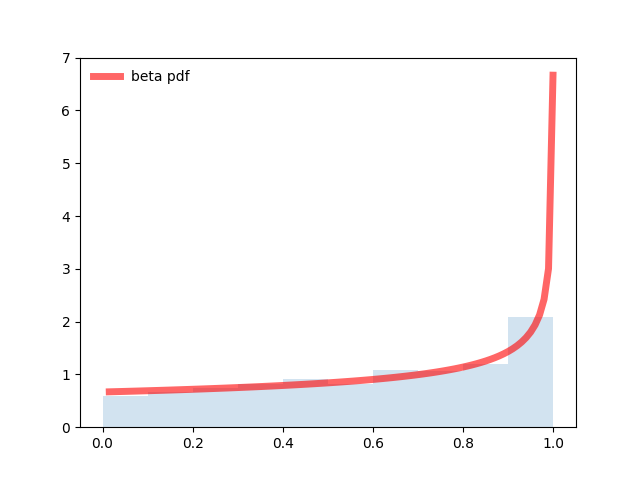

In [33]:
# Generates a 1000-element random sample from the beta distribution
# with parameters alpha = 1 and beta = 2/3

a = 1
b = 2/3

# Plots the beta distribution

beta_distribution_plot(a, b)

**2) A random sample of 1000 Californians is taken, 65% support the death penalty. What are your posterior mean and variance ? Plot the posterior density function.**

We denote $\theta$ the probability of a californian supporting the death penalty. And we assume the prior distribution:
$$\theta \sim Beta(1, \frac{2}{3})$$

Let denote by $y$ the random variable describing the number of californian supporting the death penalty in the observed population. We assume drawing from the population to be an independent operation. As such we consider a binomial distribution for y|$\theta$.
Thus the data likelihood is given by: 

$$p(y=k|\theta) = \binom{n}{k}\theta^{k}(1-\theta)^{n-k}$$With $n=1000$ and $k=650$.

We can give the posterior probability of $\theta$ (up to a constant) by using Bayes' such that:

\begin{align}
p(\theta|y) &\propto p(y|\theta)p(\theta) \\
& \propto \theta^{k+\alpha-1}(1-\theta)^{n-k+\beta-1} \\
\end{align}

This implies:

\begin{align}
\theta|y & \sim Beta(\alpha+k, n-k+\beta)
\end{align}

With $\alpha=1$, $\beta=\frac{2}{3}$, $n=1000$ and $k=650$. I.e.:

$$\theta|y \sim Beta(651, 350+\frac{2}{3})$$

As such, and using the formulas listed in question 1, we find:

| posterior statistics | value (rounded to 4 decimals) | fraction (obtained via Wolfram Alpha) |
| --- | --- | --- |
| mean | 0.6499 | $\frac{1953}{3005}$ |
| variance | 0.0002 | $\frac{1540917}{6790578800}$ |

This implies a standard deviation of c. 0.0151.

<u>Comment:</u>

The update of the posterior distribution results in a much tighter spread (lower variance). The random sample of 1,000 Californians strongly affected our belief in the distribution of the Californian support for death penalty.

In [34]:
n = 1000
k = 650
new_a = a+k
new_b = b+n-k

mean, var = beta.stats(new_a, new_b)

print(f"The posterior distribution Beta({new_a}, {np.round(new_b, 4)}) has",
      f"mean {np.round(mean, 4)} and variance {np.round(var, 4)}",
      "(rounded to 4 decimals).")

The posterior distribution Beta(651, 350.6667) has mean 0.6499 and variance 0.0002 (rounded to 4 decimals).


<IPython.core.display.Javascript object>


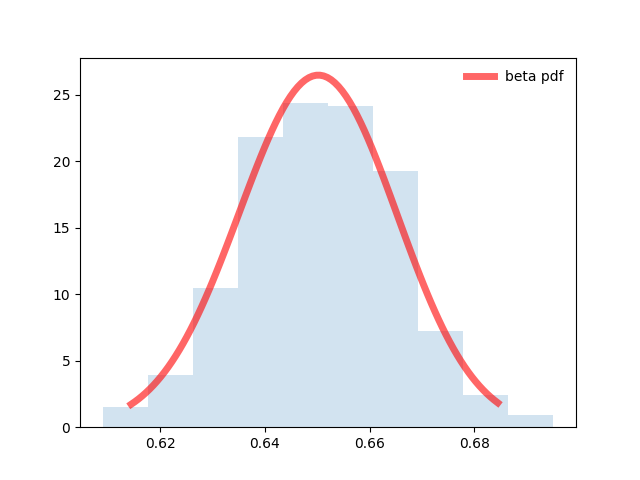

In [35]:
# Plots the beta distribution 

beta_distribution_plot(new_a, new_b)

<IPython.core.display.Javascript object>


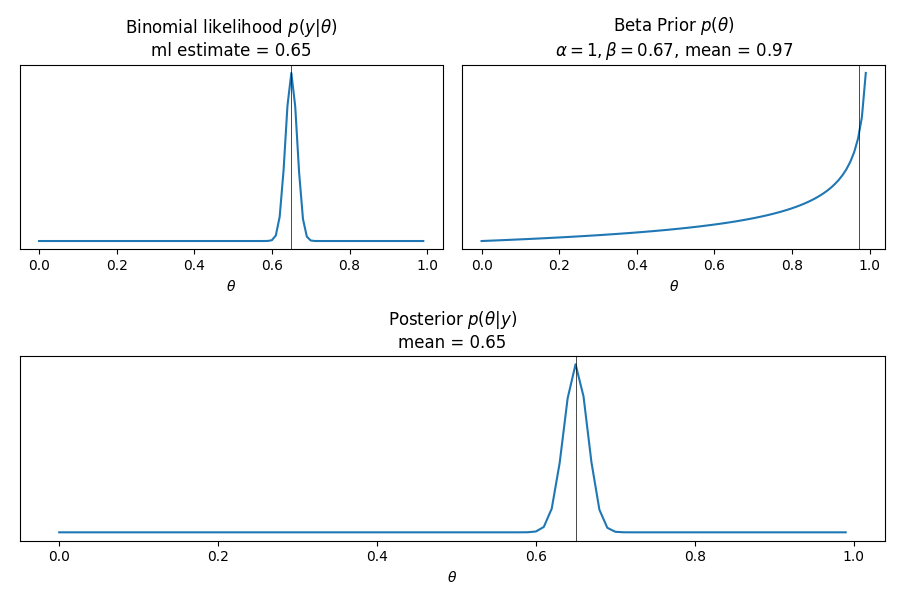

In [36]:
plot_numerical_approximation_posterior(a, b, n, k)

**3) Examine the impact of the prior parameters on the posterior distribution through different statistics (i.e mean, median, 95% posterior interval).**

<u>Observations:</u>

We iterate over the every permutation of alpha and beta parameter for the posterior distribution with respective range 1, 5 up to 50 in steps of 5, i.e. 121 different permutations.

Given the dat and results displayed below, we identify the following trends:

- We see that increasing the value of the $\alpha$ parameter leads to increasing statistics (i.e. mean and median) while increasing the value of $\beta$ leads to decreases. However, we see that the impact of $\beta$ is superior to that of $\alpha$ when both are grown concurrently (e.g. the mean and median of the distribution for $(\alpha=1, \beta=1)$ are higher than for $(\alpha=50, \beta=50)$).

- Since the Beta distribution is equivalent to the Uniform distribution when $\alpha$ and $\beta$ are set to 1, it means that, as we grow the values of the parameters of the prior distribution, we tend to bias the posterior distribution at an increasing rate.

- Furthermore, we see that the spread of the 95% confidence interval seems to be relatively stable around a mean point of 0.049.

<IPython.core.display.Javascript object>


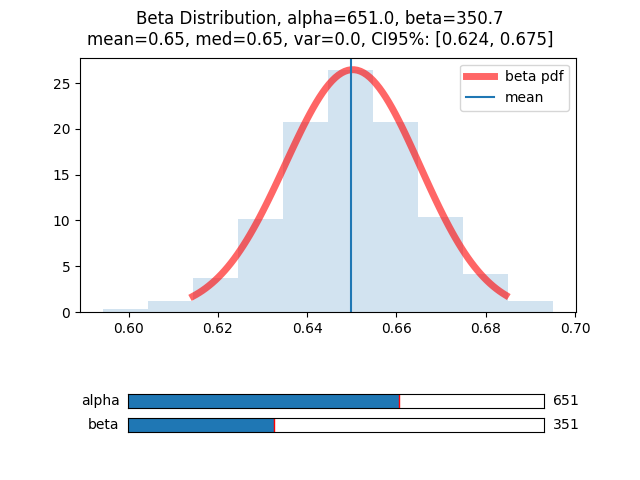

In [37]:
#/!\ It is import that the function returns fig, ax, and the slider objects,
#    here stored in variable f, otherwise the plot will be unresponsive outside 
#    the function's scope:
#    > https://github.com/matplotlib/matplotlib/issues/3105

f = beta_distribution_sliderplot(1., 2/3, 1000, 650)

**/!\** *The sliders above can be dynamically changed when the kernel is started and rerun.*

In [38]:
results, heatmap_post_mean, heatmap_post_median = \
        compute_priors_impact_on_posterior_beta_distribution(1000, 650)

In [39]:
results

,alpha,beta,post. alpha,post. beta,post. mean,post. median,95% post. CI,CI spread
0,1,1,651,351,0.649701,0.649800,"[0.625, 0.673]",0.048288
1,1,5,651,355,0.647117,0.647215,"[0.621, 0.671]",0.049788
2,1,10,651,360,0.643917,0.644012,"[0.62, 0.669]",0.048609
3,1,15,651,365,0.640748,0.640840,"[0.615, 0.666]",0.051461
4,1,20,651,370,0.637610,0.637700,"[0.614, 0.663]",0.049433
...,...,...,...,...,...,...,...,...
116,50,30,700,380,0.648148,0.648240,"[0.626, 0.672]",0.046255
117,50,35,700,385,0.645161,0.645251,"[0.62, 0.669]",0.048876
118,50,40,700,390,0.642202,0.642289,"[0.619, 0.666]",0.047261
119,50,45,700,395,0.639269,0.639354,"[0.615, 0.664]",0.048866


In [40]:
print("The spread of the 95% confidence interval centers around a",
      f"mean point of {round(results['CI spread'].mean(), 4)}",
      f"with standard deviation {round(results['CI spread'].std(), 4)}.")

The spread of the 95% confidence interval centers around a mean point of 0.0483 with standard deviation 0.0015.


In [41]:
heatmap_post_mean

In [42]:
heatmap_post_median

<hr>

## Exercise 4

**1) Which of the expressions below correspond to the statement: *the probability of rain on Monday* ?**

- *Pr(rain)*
- **Pr(rain|Monday)** <-
- *Pr(Monday|rain)*
- **Pr(rain, Monday) / Pr(Monday)** <-


**2) Which of the following statements corresponds to the expression: *Pr(Monday|rain)* ?**

- *The probability of rain on Monday.*
- *The probability of rain, given that it is Monday.*
- **The probability that it is Monday, given that it is raining.** <-
- *The probability that it is Monday and it is raining.*


**3) Which of the expressions below correspond to the statement: *the probability that it is Monday, given that it is raining* ?**

- **Pr(Monday|rain)** <-
- *Pr(rain|Monday)*
- *Pr(rain | Monday)Pr(Monday)*
- **Pr(rain | Monday)Pr(Monday)/Pr(rain)** <-
- *Pr(Monday|rain)Pr(rain)/Pr(Monday)*

<hr>

## Exercise 5

Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them appart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research. Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. 

**What is the probability that her next birth will also be twins ?**

We set the following:

- $P_A$, the event that a panda is of the species A
- $P_B$, the event that a panda is of the species B
- ${offspring}_{twin}$ or $O_t$, the event that a female panda gives birth to twins
- ${offspring}_{singleton}$ or $O_s$, the event that a female panda gives birth to a single offspring

By the information provided in the instructions, we have:

\begin{align}
\mathbb{P}(P_A) &= \frac{1}{2} \\
\mathbb{P}(P_B) &= \frac{1}{2} \\
\mathbb{P}(O_t|P_A) &= \frac{1}{10} \\
\mathbb{P}(O_s|P_A) &= \frac{1}{5} \\
\end{align}

We now denote:

- ${now}_{O_t}$, the event that a female panda gave birth to twins
- ${future}_{O_t}$, the event that the next litter of a female panda will be twins

As such, we set the probability that the next litter of a female panda will be twins, given that its current litter were twins as:

$$\mathbb{P}({future}_{O_t}|{now}_{O_t})$$

Based on this formulation of the problem we have:

\begin{align}
\mathbb{P}({future}_{O_t}|{now}_{O_t}) &= \frac{\mathbb{P}({future}_{O_t} \cap {now}_{O_t})}{\mathbb{P}({now}_{O_t})} \\
&= \frac{\mathbb{P}({future}_{O_t} \cap {now}_{O_t} \cap P_A) + \mathbb{P}({future}_{O_t} \cap {now}_{O_t} \cap P_B)}{\mathbb{P}({now}_{O_t} \cap P_A) + \mathbb{P}({now}_{O_t} \cap P_B)} \\
&= \frac{\mathbb{P}({future}_{O_t} \cap {now}_{O_t} | P_A)\mathbb{P}(P_A) + \mathbb{P}({future}_{O_t} \cap {now}_{O_t} | P_B)\mathbb{P}(P_B)}{\mathbb{P}({now}_{O_t} | P_A)\mathbb{P}(P_A) + \mathbb{P}({now}_{O_t} | P_B)\mathbb{P}(P_B)}, \text{ Marginal prob. rule}\\
&= \frac{\mathbb{P}({future}_{O_t}|P_A)\mathbb{P}({now}_{O_t}|P_A)\mathbb{P}(P_A) + \mathbb{P}({future}_{O_t}|P_B)\mathbb{P}({now}_{O_t} | P_B)\mathbb{P}(P_B)}{\mathbb{P}({now}_{O_t} | P_A)\mathbb{P}(P_A) + \mathbb{P}({now}_{O_t} | P_B)\mathbb{P}(P_B)}, \text{ births are independent}\\
&=\frac{(\frac{1}{10})^2*\frac{1}{2}+(\frac{1}{5})^2*\frac{1}{2}}{\frac{1}{10}*\frac{1}{2}+\frac{1}{5}*\frac{1}{2}} \\
&=\frac{(\frac{1}{10})^2+(\frac{1}{5})^2}{\frac{1}{10}+\frac{1}{5}} \\
&=\frac{1}{20}*\frac{10}{3}\\
\mathbb{P}({future}_{O_t}|{now}_{O_t})&=\frac{1}{6}
\end{align}

We conclude that the probability that the female panda's next birth will be twins is $\frac{1}{6}$.